In [1]:
note="supdisps_thin_400k"

In [2]:
# This one uses processed Ws inputs, so one does not have to input the array sizes manually
import qpms
from qpms.symmetries import  gen_hexlattice_Kpoint_svwf_rep, gen_hexlattice_Kpoint_svwf_rep_projectors
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath
chunksize=10

In [3]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [4]:
#Wfile = '/m/phys/project/qd/Marek/ultrathin_cs_200k/ut.4'
#Wfile = '/m/phys/project/qd/Marek/ultrathin_cs_200k/ut'
#Wfile = '/m/phys/project/qd/Marek/sup_lMax3_cs_400k_broad/z'
Wfile = '/m/phys/project/qd/Marek/sup_lMax3_cs_400k/w.1'

In [5]:
#freqlims = (1.436*eV/hbar,1.443*eV/hbar)
#freqlims = (1.439*eV/hbar,1.443*eV/hbar)
freqlims=None

In [6]:
#wdata = wdata_long
wdata_head = qpms.loadWfile_info(Wfile, lMax=3, midk_halfwidth=None,freqlimits=freqlims)
lMax = wdata_head['lMax']
nelem = wdata_head['nelem']
nfreqs_total = wdata_head['nfreqs']

In [7]:
#wdata.keys(), wdata['nk'], wdata['ks'], wdata['Ws'].shape

In [8]:
#### T-matrices from file
# Original Ag:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper_freqscale_finer/cylinder_50nm_lMax3_longer_freqdiv20_cleaned.TMatrix'
freqscale=20
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new', freqscale=freqscale)
tmtype="Scuff"

In [9]:
# TODO synchronize the TM/W lMaxes better
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
lMaxTM = lMax

In [10]:
#### Alternatively, Mie T-matrix
#lMaxTM = force_lMax
lMax = lMaxTM

nelem = lMax * (lMax + 2)
startω =1*eV/ℏ
stopω = 2*eV/ℏ
ωlist = np.linspace(startω, stopω, 200)


ε_b = 2.13
R = 45.428e-9

if False: # drude model
    ω_p = 9*eV/ℏ #9*eV/ℏ
    ε_inf = 4.6
    γ_p = 0#0.07*eV/ℏ
    
    ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)
    tmtype="MieDrude%gnm" % (R/1e-9)
else: # interpolated data
    permdata = np.loadtxt("/u/46/necadam1/unix/tmatrix-experiments/materialy/Au-Johnson-simple.dat")
    permfreqs = permdata[:,0]
    permvals = permdata[:,1] + permdata[:,2]*1j
    permdata_interp = interpolate.interp1d(permfreqs, permvals, axis = 0, kind='linear', fill_value='extrapolate')
    ε_mlist = permdata_interp(ωlist)
    tmtype="MieInterp%gnm" % (R/1e-9)
    

RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

y = np.arange(nelem)
my, ny = qpms.get_mn_y(lMax)

TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

for l in range(1,lMax+1):
    beg = l**2-1
    end = l*(l+2)
    TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
    TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

freqs_orig = ωlist

In [11]:
lMax = lMaxTM  # redundant
nelem = qpms.get_nelem(lMax) #redundant
nomega = wdata_head['nfreqs'] # 286
nk = wdata_head['nk'] #100
npart = wdata_head['npart']
wdata_head['freqs'][0]/(eV/hbar), wdata_head['freqs'][-1] / (eV/hbar)

(1.4207542474262045, 1.4602196431880436)

In [12]:
#nomega, nk, wdata['freqs'][151]/(eV/hbar), wdata['freqs'][-125] / (eV/hbar), wdata['ks'][12][1], wdata['ks'][-33][1]
nomega, nk, wdata_head['freqs'][151]/(eV/hbar), wdata_head['freqs'][-125] / (eV/hbar), wdata_head['ks'][22][1]*4.085/4.199, wdata_head['ks'][-19][1]*4.085/4.199

(4001,
 400,
 1.4222440661162141,
 1.4589962159194265,
 4011913.9972288474,
 4158551.863753502)

In [13]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [14]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [15]:
#Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = np.broadcast_to(wdata_head['ks'][ň,:,:], (nomega, nk, 2))
freqs = np.broadcast_to(wdata_head['freqs'][:,ň], (nomega,nk))

#Wmatrices.shape, 
ks.shape, freqs.shape


((4001, 400, 2), (4001, 400))

In [16]:
TMatrices_orig.shape, ks.shape, freqs.shape

((200, 2, 15, 2, 15), (4001, 400, 2), (4001, 400))

# Full problem
TE_or_TM = None # just that the scripts below know...
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki]) * 1
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)), 
                                                                        lapack_driver= 'gesvd')
        except ValueError:
            pass
restype="Full"                

In [22]:
# Z-symmetric problem
TE_or_TM = 0 # 0 is TE

TE_yz = np.arange(nelem)
TM_yz = TE_yz
my, ny = qpms.get_mn_y(lMax)
TE_NMz = (my + ny) % 2
TM_NMz = (1 - TE_NMz)
T_NMz = TE_NMz if TE_or_TM == 0 else TM_NMz
T_yz = TE_yz if TE_or_TM == 0 else TM_yz
y = np.arange(nelem)
yi = y[ň,ň,ň,:]
yj = y[ň,:,ň,ň]
ipart = np.arange(npart)
ti = np.arange(2)

#allU = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
#allV = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*nelem), np.nan)
wdata = qpms.loadWfile_processed(Wfile, lMax=3, midk_halfwidth=None, freqlimits=freqlims, iteratechunk = chunksize)
for Wchunk in wdata:
    Wmatrices = Wchunk['Ws']
    for omi in range(*Wchunk['chunk_range']):
        chunk_omi = omi-Wchunk['chunk_range'][0]
        for ki in range(nk):
            W = Wmatrices[chunk_omi,ki][..., ipart[:,ň,ň,ň], T_NMz[ň,:,ň,ň],T_yz[ň,:,ň,ň], ipart[ň,ň,:,ň], T_NMz[ň,ň,ň,:],T_yz[ň,ň,ň,:]] # [Npart,2,nelem,Npart,2,nelem] -> [Npart,nelem,Npart,nelem]
            W[np.isclose(W,0, atol = 1e-10)] = 0
            T = TMatrices_interp(freqs[omi,ki])[...,T_NMz[:,ň],T_yz[:,ň],T_NMz[ň,:],T_yz[ň,:]]  #[2,nelem,2,nelem] -> [nelem,nelem]
            TW = np.sum(
                T[...,ň,:,:,ň,ň] * W[...,:,ň,:,:,:]
            , axis = (-3))
            iden = np.eye(npart*nelem)
            iden.shape = (npart,nelem,npart,nelem)
            finalMatrix = iden-TW
            try:
                #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                allS[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), compute_uv = False,
                                                                           # lapack_driver= 'gesvd'
                                                                           )
            except ValueError:
                pass

#theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
#allV_expanded = np.zeros((nomega,nk,npart*nelem,2,2,nelem),dtype=complex)
#for t in (0,1):
#    allV_expanded[:,:,:,:,t,T_NMz == t]  = allV.reshape((nomega,nk,npart*nelem,npart,nelem))[:,:,:,:,T_NMz == t]

if TE_or_TM == 0:
    restype="E-inplane"
elif TE_or_TM == 1:
    restype="M-inplane"
else:
    restype="WTF"

In [23]:
freqs.shape, nk

((4001, 400), 400)

In [24]:
%matplotlib inline
def make_image(data, outputname, size=(1.1, 1.5), dpi=300):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #plt.set_cmap('hot')
    ax.pcolormesh(data, #aspect='equal'
             )
    plt.savefig(outputname, dpi=dpi)

In [25]:
#make_image(np.clip(np.log(1-allS[151:-125,12:-33,-1]), -11, -2), "figs/lMax%d%s%s%s_disp_big_n.pdf"%(lMax,tmtype,restype,note), dpi=900)
#make_image(np.clip(np.log(1-allS[151:-125,22:-19,-1]), -11, -2), "figs/lMax%d%s%s%s_disp_big_n.png"%(lMax,tmtype,restype,note), dpi=900) # posun k-bodu na špatně zkalibrované měření

In [26]:
np.savez("/m/phys/project/qd/Marek/dispdata/lMax%d%s%s%s_dispdata.npz"%(lMax,tmtype,restype,note), leastSVs = allS[:,:,-1], ks=ks[:,:,1], freqs=freqs)

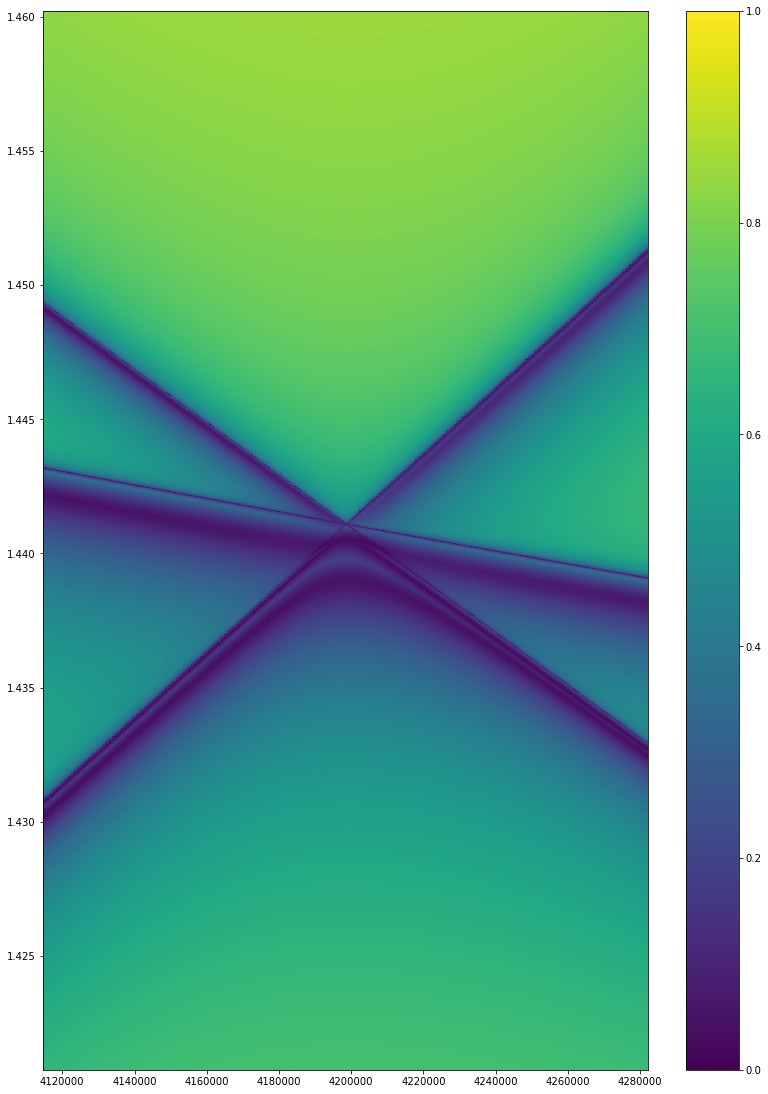

In [27]:
%matplotlib inline
plot_margin=0
#plt.figure(figsize=(2.25,3.75))
plt.figure(figsize=(11,15))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, allS[:,:,-1], vmin=0, vmax=1)
#plt.imshow(np.clip(np.log(1-allS[:,:,-1]),-11.5,-3.8), origin = 'lower')
#plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, np.clip(np.log(1-allS[:,:,-1]), -11, -2))

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
#plt.axis('off')
plt.colorbar()
plt.tight_layout(pad=0)
plt.savefig("figs/lMax%d%s%s%s_dispbg.png"%(lMax,tmtype,restype,note), #bbox_inches='tight'
           )

In [28]:
print (freqs[0,0]/eV*hbar, freqs[-1,0]/eV*hbar)

1.4207542474262043 1.4602196431880436


In [29]:
wdata_head['freqs_weirdunits'][1], wdata_head['freqs'][500]/eV*hbar

(7.20005, 1.425687421896434)

In [30]:
Wfile = '/m/phys/project/qd/Marek/lMax3_onlyK_fine/w'
lMax = 3
npart=2
nelem = lMax * (lMax+2)
wdata_thin = qpms.loadWfile_processed(Wfile, lMax=3, midk_halfwidth=0,freqlimits=None)
Wmatrices = wdata_thin['Ws'][::4]
print(Wmatrices.shape)
nk = wdata_thin['nk']
freqs = wdata_thin['freqs'][::4]
nfreqs = len(freqs)
nomega = nfreqs
ks = wdata_thin['ks']
#lMax = wdata_head['lMax']
#nelem = wdata_head['nelem']

lineindex = nk//2
linek = ks[0,lineindex]
linefreqs = freqs
lineWmatrices = Wmatrices[:,lineindex]


(5105, 1, 2, 2, 15, 2, 2, 15)


In [31]:
### Zde se vybírá ""číslo"" modu
psi = 1
reps =  gen_hexlattice_Kpoint_svwf_rep(lMax, psi, vflip='y')
projmats, bases = gen_hexlattice_Kpoint_svwf_rep_projectors(lMax,psi, vflip='y',do_bases=True)

In [32]:
WMatrices_projs = dict()
for rep, P in projmats.items():
    WP = np.tensordot(lineWmatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PWP = np.tensordot(P,WP, axes=([-3,-2,-1],[1,2,3]))
    PWP = np.rollaxis(PWP, 3)
    WMatrices_projs[rep] = PWP

WMatrices_reconstructed = np.zeros(lineWmatrices.shape, dtype=complex)
for PWP in WMatrices_projs.values():
    WMatrices_reconstructed += PWP

(np.amax(np.nan_to_num(np.abs(WMatrices_reconstructed-lineWmatrices)/(np.abs(WMatrices_reconstructed)+np.abs(lineWmatrices)))),
 np.amax(np.abs(WMatrices_reconstructed-lineWmatrices)))

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


(1.0, 3.18313815262936e-11)

In [33]:
finalMatrices = np.empty((nomega, npart,2,nelem, npart,2,nelem), dtype=complex)
# Full problem
for omi in range(nomega):
        W = lineWmatrices[omi]
        T = TMatrices_interp(linefreqs[omi])
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        finalMatrices[omi] = finalMatrix

In [34]:
# test whether the symmetry group is correct (now mainly whether the psi sign is correct)
finalMatrices_projs = dict()
for rep, P in projmats.items():
    MP = np.tensordot(finalMatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PMP = np.tensordot(P,MP, axes=([-3,-2,-1],[1,2,3]))
    PMP = np.rollaxis(PMP, 3)
    finalMatrices_projs[rep] = PMP

finalMatrices_reconstructed = np.zeros(finalMatrices.shape, dtype=complex)
for PMP in finalMatrices_projs.values():
    finalMatrices_reconstructed += PMP

In [35]:
lineS_irrep = dict()
for rep, B in bases.items():
    N = B.shape[0]
    lineS_thisirrep = np.full((nomega,N), np.nan)
    #B_H = np.moveaxis(B,0, -1).conj() # (N,2,2,nelem) -> (2,2,nelem,N)
    B_H = B.conj()
    B = np.moveaxis(B,0,-1)
    for omi in range(nomega):
            M = finalMatrices[omi]
            MB = np.tensordot(M,B,axes=([-3,-2,-1],[0,1,2]))
            finalMatrix_irrep = np.tensordot(B_H, MB, axes=([-3,-2,-1],[0,1,2]))
            try:
                #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                lineS_thisirrep[omi] = scipy.linalg.svd(finalMatrix_irrep, compute_uv = False,
                                                                           # lapack_driver= 'gesvd'
                                                                           )
            except ValueError:
                pass
    lineS_irrep[rep] = lineS_thisirrep

    
  

E' 1.4405264107028857
A1' 1.4410789262435517
A2' 1.439006992966055
E'' 1.439046458361817
A1'' 1.441157857035075
A2'' 1.4410789262435517


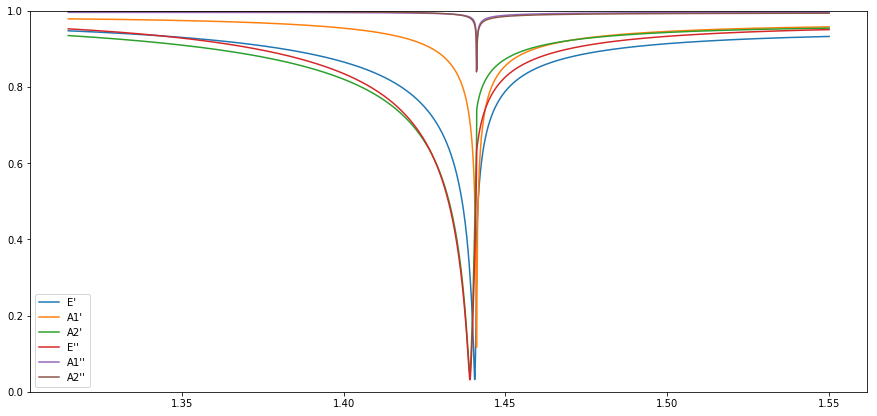

In [36]:
%matplotlib inline
s = 1
plt.figure(figsize=(15,7))
amaxes = []
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    lineSp = lineS_irrep[rep]
    plt.plot(linefreqs/eV*hbar, lineSp[:,-s], label=rep)
    amaxes.append(np.amax(lineSp[:,-s]))
plt.ylim([0,min(2, max(amaxes))])

plt.legend()
plt.savefig("figs/lMax%d%sPsi%d%s_irrep_SVs%d.pdf"%(lMax,tmtype,psi,note,s))
"figs/lMax%d%sPsi%d%s_irrep_SVs%d.pdf"%(lMax,tmtype,psi,note,s)
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    print(rep, linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar)

In [37]:
lineS1_irreps = dict()
for rep, val in lineS_irrep.items():
    lineS1_irreps[rep] = val[:,-1]

In [38]:

np.savez("/m/phys/project/qd/Marek/dispdata/lMax%d%s%s_crosscut.npz"%(lMax,tmtype,note), **lineS1_irreps, ks=ks[...,1], freqs=freqs)
print("/m/phys/project/qd/Marek/dispdata/lMax%d%s%s_crosscut.npz"%(lMax,tmtype,note))

/m/phys/project/qd/Marek/dispdata/lMax3MieInterp45.428nmsupdisps_thin_400k_crosscut.npz


In [39]:
ks.shape

(1, 2)

In [40]:
print(lineS_irrep.keys())

dict_keys(["E''", "A2'", "A1''", "A1'", "E'", "A2''"])
